In [1]:
# === Import Libraries ===
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import ADASYN
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import joblib

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")


In [2]:
# === Download NLTK Resources ===
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kunal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kunal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# === Load Data ===
train_data = pd.read_csv('train.csv')
print("Train Data Head:")
print(train_data.head())

print("\nMissing Values in Train Data:")
print(train_data.isnull().sum())

# Drop rows with missing text
train_data = train_data.dropna(subset=['crimeaditionalinfo'])

# Fill missing sub_category values with 'Unknown'
train_data['sub_category'] = train_data['sub_category'].fillna('Unknown')


Train Data Head:
                                category                       sub_category  \
0  Online and Social Media Related Crime  Cyber Bullying  Stalking  Sexting   
1                 Online Financial Fraud                  Fraud CallVishing   
2               Online Gambling  Betting           Online Gambling  Betting   
3  Online and Social Media Related Crime                   Online Job Fraud   
4                 Online Financial Fraud                  Fraud CallVishing   

                                  crimeaditionalinfo  
0  I had continue received random calls and abusi...  
1  The above fraudster is continuously messaging ...  
2  He is acting like a police and demanding for m...  
3  In apna Job I have applied for job interview f...  
4  I received a call from lady stating that she w...  

Missing Values in Train Data:
category                 0
sub_category          6591
crimeaditionalinfo      21
dtype: int64


In [4]:
# === Preprocess Text Data ===
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
train_data['processed_text'] = train_data['crimeaditionalinfo'].apply(preprocess_text)

print("\nProcessed Text Sample:")
print(train_data[['crimeaditionalinfo', 'processed_text']].head())



Processed Text Sample:
                                  crimeaditionalinfo  \
0  I had continue received random calls and abusi...   
1  The above fraudster is continuously messaging ...   
2  He is acting like a police and demanding for m...   
3  In apna Job I have applied for job interview f...   
4  I received a call from lady stating that she w...   

                                      processed_text  
0  continu receiv random call abus messag whatsap...  
1  fraudster continu messag ask pay money send fa...  
2  act like polic demand money ad section text me...  
3  apna job appli job interview telecal resourc m...  
4  receiv call ladi state send new phone vivo rec...  


In [5]:
# === Feature Extraction (TF-IDF) ===
tfidf = TfidfVectorizer(max_features=500)
X_train = tfidf.fit_transform(train_data['processed_text']).toarray()

# Save the TF-IDF model for reuse
joblib.dump(tfidf, 'tfidf_pipeline_optimized.pkl')
print("\nTF-IDF pipeline saved as 'tfidf_pipeline_optimized.pkl'.")

# Target variable
y_train_cat = train_data['category']
print("\nTF-IDF Feature Matrix Shape:", X_train.shape)



TF-IDF pipeline saved as 'tfidf_pipeline_optimized.pkl'.

TF-IDF Feature Matrix Shape: (93665, 500)


In [6]:
# === Data Balancing with ADASYN ===
min_class_samples = y_train_cat.value_counts().min()

if min_class_samples > 1:
    balancer = ADASYN(random_state=42, n_neighbors=min(5, min_class_samples - 1))
    X_train_balanced, y_train_balanced = balancer.fit_resample(X_train, y_train_cat)
else:
    print("\nSkipping balancing as some classes have fewer than 2 samples.")
    X_train_balanced, y_train_balanced = X_train, y_train_cat

print("\nClass Distribution After Balancing:")
print(pd.Series(y_train_balanced).value_counts())



Skipping balancing as some classes have fewer than 2 samples.

Class Distribution After Balancing:
category
Online Financial Fraud                                  57416
Online and Social Media Related Crime                   12138
Any Other Cyber Crime                                   10877
Cyber Attack/ Dependent Crimes                           3608
RapeGang Rape RGRSexually Abusive Content                2822
Sexually Obscene material                                1838
Hacking  Damage to computercomputer system etc           1710
Sexually Explicit Act                                    1552
Cryptocurrency Crime                                      480
Online Gambling  Betting                                  444
Child Pornography CPChild Sexual Abuse Material CSAM      379
Online Cyber Trafficking                                  183
Cyber Terrorism                                           161
Ransomware                                                 56
Report Unlawful Content

In [7]:
# === Encode Labels and Model Training ===
label_encoder = LabelEncoder()
y_train_balanced_encoded = label_encoder.fit_transform(y_train_balanced)

xgb_cat = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb_cat.fit(X_train_balanced, y_train_balanced_encoded)

# Save the model
joblib.dump(xgb_cat, 'xgb_category_model_optimized.pkl')
print("\nModel saved as 'xgb_category_model_optimized.pkl'.")



Model saved as 'xgb_category_model_optimized.pkl'.


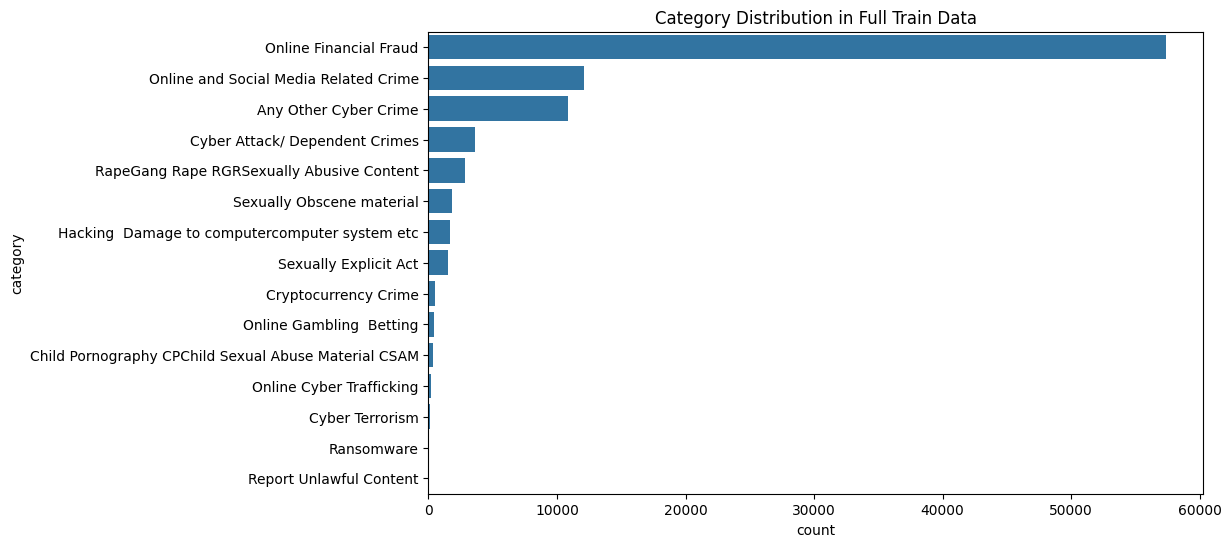

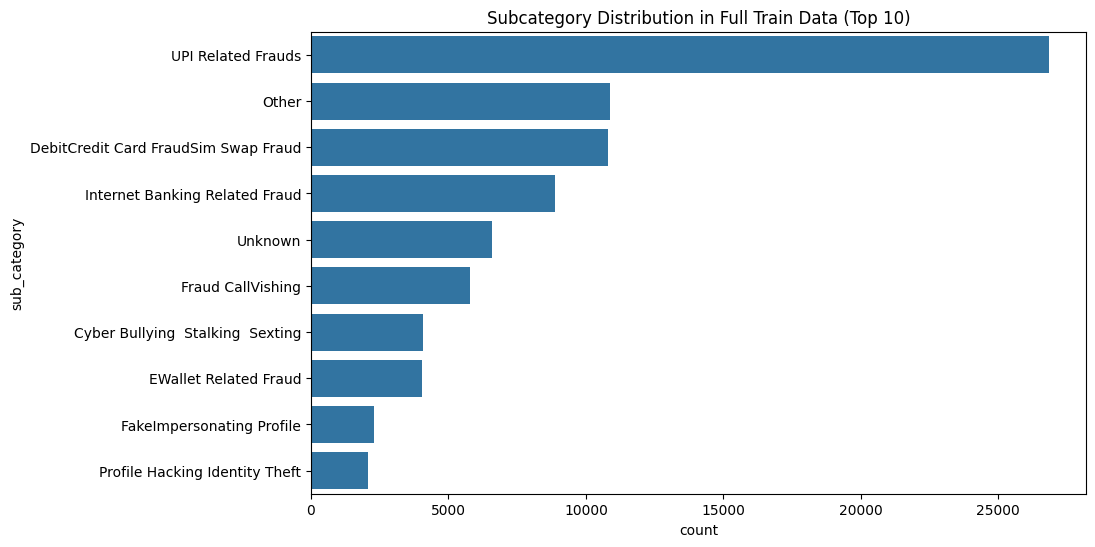

In [8]:
# === Visualization ===
# Plot Category Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, y='category', order=train_data['category'].value_counts().index)
plt.title('Category Distribution in Full Train Data')
plt.show()

# Plot Subcategory Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, y='sub_category', order=train_data['sub_category'].value_counts().index[:10])
plt.title('Subcategory Distribution in Full Train Data (Top 10)')
plt.show()


In [9]:
# === Evaluation on Full Data ===
loaded_model = joblib.load('xgb_category_model_optimized.pkl')
print("\nLoaded model from 'xgb_category_model_optimized.pkl'.")

# Predict on the entire training set
y_pred_full = loaded_model.predict(X_train)

# Evaluate predictions
y_train_encoded = label_encoder.transform(y_train_cat)

print("\nAccuracy of Loaded Model on Full Dataset:", accuracy_score(y_train_encoded, y_pred_full))

print("\nClassification Report for Loaded Model (Full Data):\n",
      classification_report(y_train_encoded, y_pred_full, target_names=label_encoder.classes_))



Loaded model from 'xgb_category_model_optimized.pkl'.

Accuracy of Loaded Model on Full Dataset: 0.8283350237548711

Classification Report for Loaded Model (Full Data):
                                                       precision    recall  f1-score   support

                               Any Other Cyber Crime       0.76      0.36      0.49     10877
Child Pornography CPChild Sexual Abuse Material CSAM       0.94      0.57      0.71       379
                                Cryptocurrency Crime       0.97      0.71      0.82       480
                      Cyber Attack/ Dependent Crimes       1.00      1.00      1.00      3608
                                     Cyber Terrorism       1.00      0.47      0.64       161
      Hacking  Damage to computercomputer system etc       0.81      0.62      0.71      1710
                            Online Cyber Trafficking       1.00      0.22      0.37       183
                              Online Financial Fraud       0.84      0.98   


Total Misclassifications: 16079

Sample Misclassified Cases:
                                       Actual  \
2                    Online Gambling  Betting   
3       Online and Social Media Related Crime   
8   RapeGang Rape RGRSexually Abusive Content   
9                       Any Other Cyber Crime   
11                      Any Other Cyber Crime   
22                   Online Gambling  Betting   
23      Online and Social Media Related Crime   
27      Online and Social Media Related Crime   
39                      Sexually Explicit Act   
45                  Sexually Obscene material   

                                Predicted  \
2   Online and Social Media Related Crime   
3                  Online Financial Fraud   
8   Online and Social Media Related Crime   
9                  Online Financial Fraud   
11  Online and Social Media Related Crime   
22                 Online Financial Fraud   
23                 Online Financial Fraud   
27                 Online Financial Fr

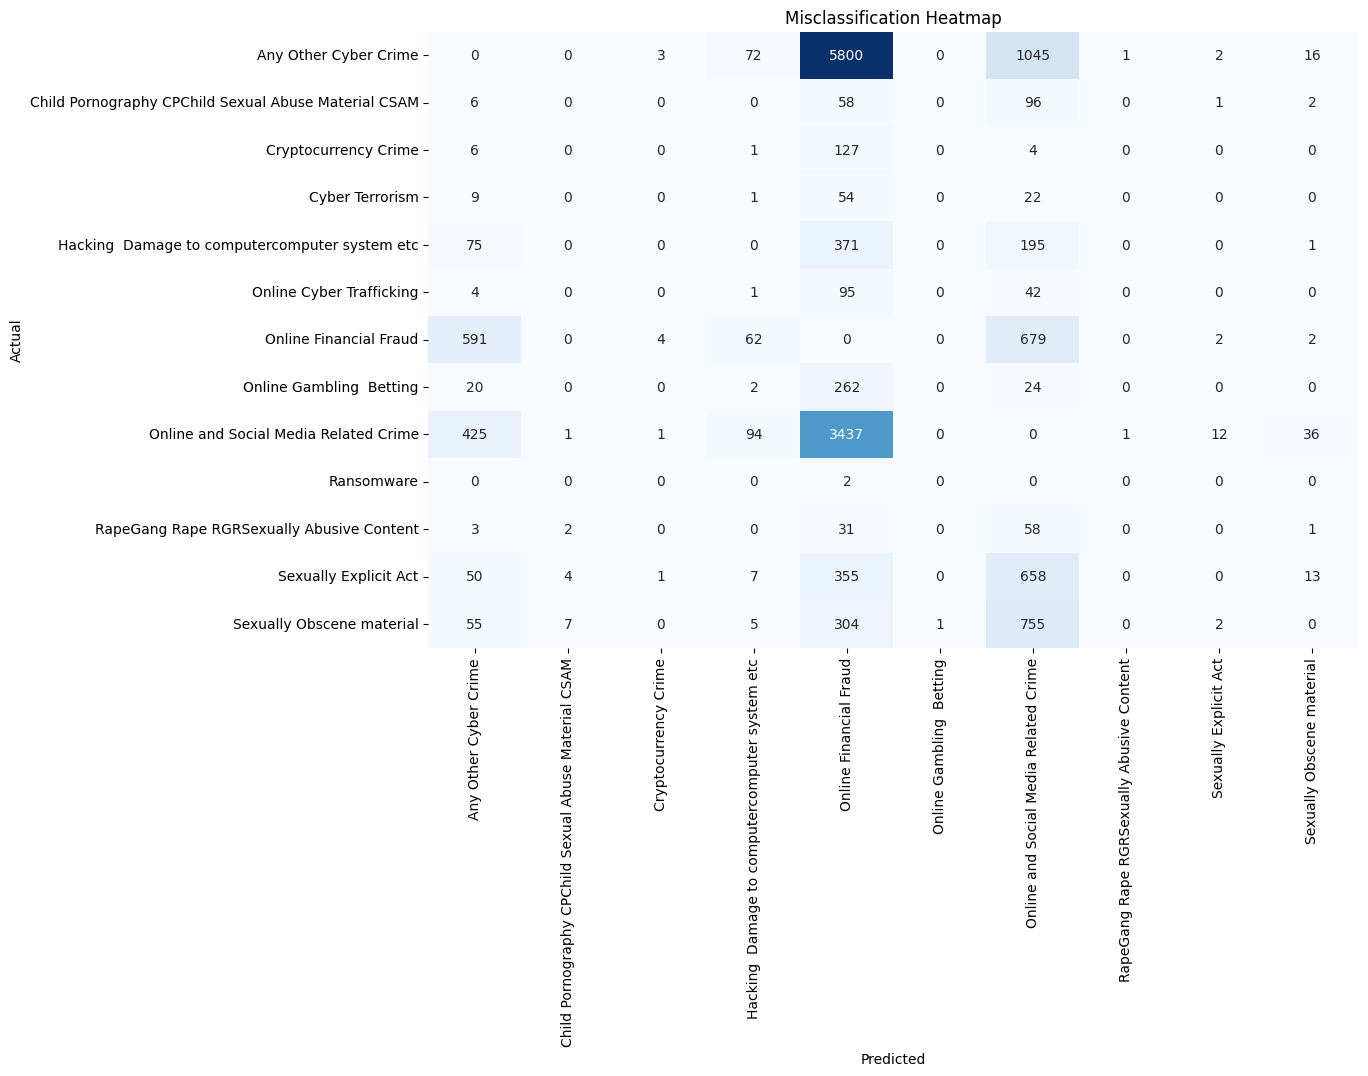

In [10]:
# === Step 11: Misclassification Analysis ===
predicted_categories = label_encoder.inverse_transform(y_pred_full)
actual_categories = y_train_cat.values

# Create a DataFrame for comparison
misclassified_df = pd.DataFrame({
    'Actual': actual_categories,
    'Predicted': predicted_categories,
    'Text': train_data['crimeaditionalinfo']
})

# Filter misclassified rows
misclassified_df = misclassified_df[misclassified_df['Actual'] != misclassified_df['Predicted']]

print(f"\nTotal Misclassifications: {len(misclassified_df)}")
print("\nSample Misclassified Cases:")
print(misclassified_df.head(10))

# Analyze common misclassifications
misclassification_counts = misclassified_df.groupby(['Actual', 'Predicted']).size().reset_index(name='Count')
misclassification_counts = misclassification_counts.sort_values(by='Count', ascending=False)

# Visualize the misclassifications
plt.figure(figsize=(12, 8))
misclassification_pivot = misclassification_counts.pivot(index='Actual', columns='Predicted', values='Count').fillna(0)
sns.heatmap(misclassification_pivot, annot=True, fmt='.0f', cmap='Blues', cbar=False)
plt.title('Misclassification Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
